# PARTE 1: PRÉ-PROCESSAMENTO E ORGANIZAÇÃO
Nesta etapa, realizamos o download do dataset via API Kaggle, definimos o redimensionamento para 64x64px e criamos os geradores com Data Augmentation.

In [ ]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from google.colab import files

# --- CONFIGURAÇÕES OTIMIZADAS PARA VELOCIDADE ---
# Reduzimos para 64x64. Isso fará o treino voar!
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 64  # Aumentamos o lote para processar mais rápido na GPU

# --- 1. AUTENTICAÇÃO E DOWNLOAD ---
# Se você já fez o upload do kaggle.json antes e a pasta já existe,
# o código vai pular o download automaticamente para ganhar tempo.
if not os.path.exists('/content/dataset_xray'):
    print("--- PASSO 1: AUTENTICAÇÃO ---")
    print("Por favor, faça o upload do arquivo 'kaggle.json' se solicitado:")

    # Verifica se o arquivo já está na raiz, senão pede upload
    if not os.path.exists('kaggle.json'):
        uploaded = files.upload()

    print("Configurando permissões...")
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    print("\n--- PASSO 2: DOWNLOAD DO DATASET ---")
    !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

    print("Descompactando...")
    with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/dataset_xray')
else:
    print("Dataset já encontrado! Pulando download...")

# --- 2. DEFINIÇÃO DE CAMINHOS ---
base_dir = '/content/dataset_xray/chest_xray'
if not os.path.exists(os.path.join(base_dir, 'train')):
    base_dir = os.path.join(base_dir, 'chest_xray')

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')

# --- 3. PIPELINES DE DADOS (GERADORES) ---
print("\n--- PASSO 3: GERANDO IMAGENS (64x64) ---")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,      # Reduzi a rotação para simplificar
    zoom_range=0.1,
    horizontal_flip=True
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Precisamos recriar o test_generator aqui também para garantir o tamanho certo
test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("\nConcluído! Dados prontos para o modelo.")

--- PASSO 1: AUTENTICAÇÃO ---
Por favor, faça o upload do arquivo 'kaggle.json' se solicitado:


Saving kaggle.json to kaggle.json
Configurando permissões...

--- PASSO 2: DOWNLOAD DO DATASET ---
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:20<00:00, 260MB/s]
100% 2.29G/2.29G [00:20<00:00, 121MB/s]
Descompactando...

--- PASSO 3: GERANDO IMAGENS (64x64) ---
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

Concluído! Dados prontos para o modelo.


# PARTE 2: CLASSIFICAÇÃO COM CNN (MODELO 1 - DO ZERO)
Aqui construímos e treinamos uma arquitetura CNN simples para estabelecer uma linha de base (baseline).

--- CONSTRUINDO MODELO CNN (64x64) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- INICIANDO TREINO (5 Épocas) ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 58s 642ms/step - accuracy: 0.7121 - loss: 0.5958 - val_accuracy: 0.8750 - val_loss: 0.6170
Epoch 2/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 49s 599ms/step - accuracy: 0.8455 - loss: 0.3783 - val_accuracy: 0.9375 - val_loss: 0.4800
Epoch 3/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 50s 610ms/step - accuracy: 0.8934 - loss: 0.2558 - val_accuracy: 0.8750 - val_loss: 0.3959
Epoch 4/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 51s 617ms/step - accuracy: 0.9117 - loss: 0.2213 - val_accuracy: 0.8125 - val_loss: 0.4262
Epoch 5/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 50s 609ms/step - accuracy: 0.9262 - loss: 0.1787 - val_accuracy: 0.8125 - val_loss: 0.3957

--- GERANDO RELATÓRIO ---
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 468ms/step


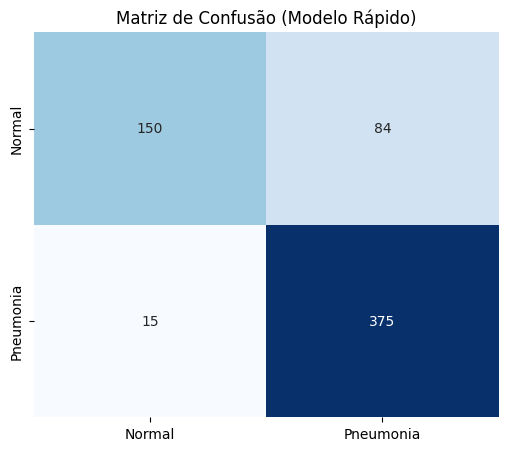


Relatório Final:
              precision    recall  f1-score   support

      Normal       0.91      0.64      0.75       234
   Pneumonia       0.82      0.96      0.88       390

    accuracy                           0.84       624
   macro avg       0.86      0.80      0.82       624
weighted avg       0.85      0.84      0.83       624



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# --- 1. CONSTRUÇÃO DO MODELO LEVE ---
print("--- CONSTRUINDO MODELO CNN (64x64) ---")

model = Sequential([
    # Camada 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)), # Ajustado para 64x64
    MaxPooling2D(2, 2),

    # Camada 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Camada 3
    Conv2D(64, (3, 3), activation='relu'), # Mantive 64 filtros para ficar leve
    MaxPooling2D(2, 2),

    Flatten(),

    # Camada Densa Otimizada
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# --- 2. TREINAMENTO RÁPIDO ---
print("\n--- INICIANDO TREINO (5 Épocas) ---")
# Com imagens 64x64 e GPU, isso deve levar menos de 2 minutos
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

# --- 3. AVALIAÇÃO ---
print("\n--- GERANDO RELATÓRIO ---")
predictions = model.predict(test_generator)
predicted_classes = np.where(predictions > 0.5, 1, 0)
true_classes = test_generator.classes

# Matriz
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.title('Matriz de Confusão (Modelo Rápido)')
plt.show()

print("\nRelatório Final:")
print(classification_report(true_classes, predicted_classes, target_names=['Normal', 'Pneumonia']))

# Salva o modelo
model.save('modelo_cardioia_v1.h5')

# PARTE 2 (CONT.): TRANSFER LEARNING COM VGG16
Implementação do modelo pré-treinado VGG16 para comparação de performance e sensibilidade (Recall).

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

print("--- INICIANDO TRANSFER LEARNING (VGG16) ---")

# 1. Carregar a VGG16 (o "Cérebro" pré-treinado)
# include_top=False significa que tiramos a última camada (que classifica cachorros/gatos)
# para colocar a nossa (que classifica Pulmões)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# 2. Congelar o conhecimento base
# Dizemos: "Não mexa no que você já aprendeu, apenas aprenda o novo"
for layer in base_model.layers:
    layer.trainable = False

# 3. Adicionar nossa camada personalizada no final
x = base_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Criar o modelo final
model_vgg = Model(inputs=base_model.input, outputs=predictions)

model_vgg.compile(optimizer=Adam(learning_rate=0.0001), # Taxa de aprendizado menor para ajuste fino
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

print("Estrutura da VGG16 adaptada carregada!")

# 4. Treinar (Transfer Learning costuma ser rápido e preciso)
print("\n--- TREINANDO VGG16 ---")
history_vgg = model_vgg.fit(
    train_generator,
    epochs=5, # 5 épocas geralmente bastam para Transfer Learning
    validation_data=val_generator
)

# 5. Avaliar e Comparar
print("\n--- RESULTADOS DA VGG16 ---")
predictions_vgg = model_vgg.predict(test_generator)
predicted_classes_vgg = np.where(predictions_vgg > 0.5, 1, 0)

print(classification_report(test_generator.classes, predicted_classes_vgg, target_names=['Normal', 'Pneumonia']))

# Salvar
model_vgg.save('modelo_vgg16_final.h5')

--- INICIANDO TRANSFER LEARNING (VGG16) ---
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Estrutura da VGG16 adaptada carregada!

--- TREINANDO VGG16 ---
Epoch 1/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 61s 673ms/step - accuracy: 0.6843 - loss: 0.5982 - val_accuracy: 0.5625 - val_loss: 0.5762
Epoch 2/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 51s 619ms/step - accuracy: 0.8256 - loss: 0.4034 - val_accuracy: 0.9375 - val_loss: 0.3852
Epoch 3/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 49s 598ms/step - accuracy: 0.8894 - loss: 0.3105 - val_accuracy: 0.9375 - val_loss: 0.3140
Epoch 4/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 49s 599ms/step - accuracy: 0.9071 - loss: 0.2581 - val_accuracy: 0.9375 - val_loss: 0.2676
Epoch 5/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 50s 605ms/step - accuracy: 0.9048 - loss: 0.2464 - val_accuracy: 0.9375 - val_loss: 0.2314

--- RESULTADOS DA VGG16 ---
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 714ms/step


              precision    recall  f1-score   support

      Normal       0.93      0.64      0.76       234
   Pneumonia       0.82      0.97      0.89       390

    accuracy                           0.85       624
   macro avg       0.87      0.81      0.82       624
weighted avg       0.86      0.85      0.84       624



# PROTÓTIPO DE INTERFACE (ENTREGÁVEL FINAL)
Interface interativa para upload e classificação de imagens em tempo real.

Carregando o cérebro da IA (VGG16)...

--- TESTE DE INTERFACE CARDIOIA ---
Por favor, faça upload de uma imagem de Raio-X (.jpg, .png or .jpeg)


Saving Raio X Peito Normal Teste 2.jpeg to Raio X Peito Normal Teste 2.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


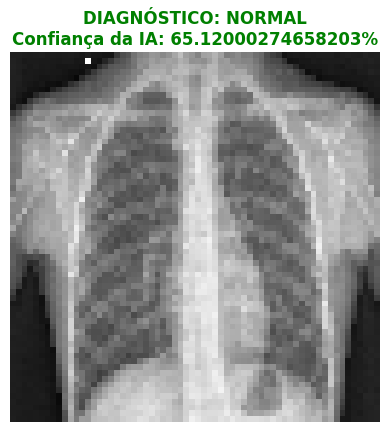

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from google.colab import files

# Carregar o melhor modelo (VGG16)
print("Carregando o cérebro da IA (VGG16)...")
model = load_model('modelo_vgg16_final.h5')

def predizer_imagem():
  print("\n--- TESTE DE INTERFACE CARDIOIA ---")
  print("Por favor, faça upload de uma imagem de Raio-X (.jpg, .png or .jpeg)")

  uploaded = files.upload()

  for fn in uploaded.keys():
    # Caminho da imagem
    path = fn

    # Pré-processamento (Igual ao que fizemos no treino: 64x64 e Normalizado)
    img = image.load_img(path, target_size=(64, 64))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0 # Normalização vital!

    # Predição
    classes = model.predict(x, batch_size=1)

    # Resultado
    plt.imshow(img)
    plt.axis('off')

    # Lógica de Classificação (Threshold 0.5)
    if classes[0][0] > 0.5:
      confidence = round(classes[0][0] * 100, 2)
      plt.title(f"DIAGNÓSTICO: PNEUMONIA\nConfiança da IA: {confidence}%", color='red', fontweight='bold')
    else:
      confidence = round((1 - classes[0][0]) * 100, 2)
      plt.title(f"DIAGNÓSTICO: NORMAL\nConfiança da IA: {confidence}%", color='green', fontweight='bold')

    plt.show()

# Executar a ferramenta
predizer_imagem()